# Proyecto 15 - Series Temporales

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Importación de librerias

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

### Carga de archivo

Para este proyecto realizamos la carga del archivo colocando la columna de fechas como indice con index_col=[0] y nos aseguramos que este índice se convierta en tipo datetime con parse_dates=[0].

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

### Inspección de datos

In [3]:
df.sample(10)

,num_orders
datetime,
2018-06-05 10:30:00,7
2018-04-23 11:10:00,7
2018-05-12 06:00:00,4
2018-07-03 18:40:00,18
2018-03-23 17:30:00,16
2018-07-24 06:20:00,4
2018-08-19 02:30:00,24
2018-03-30 12:30:00,3
2018-04-14 00:10:00,21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
len(df.index.unique())

26496

In [7]:
print(df.duplicated().sum())

26415


In [8]:
print(df.isnull().sum())

num_orders    0
dtype: int64


En este caso, los duplicados he validado que los valores unicos en índice para validar si existe un valor duplicado, ya que el numero de ordenes se repite debido a que muchos momentos tuvieron la misma cantidad de pedidos y los valores pueden repetirse en diferentes horas. Para este caso no se eliminan los duplicados. 

Por otro lado no hay valores ausentes.

En cuanto a los hallazgos en .describe() encontramos que:

- El conjunto es lo suficientemente robusto para contruir un modelo de predicción con sus 26,496 entradas.
- Esto puede interpretarse como un comportamiento típico en horarios promedio, aunque se necesita remuestreo para precisar a qué frecuencia exacta corresponde.
- Tenemos una desviación estandar (std) de 9.21, esto sugiere que la cantidad de pedidos varía notablemente entre intervalos.
- Los rangos entre el minimo y el maximo de valores va de 0 a 119 lo cual refleja que existen horas con baja demanda y horas pico, podría reflejar patrones estacionales o tendencias.



### Remuestreo de datos

Agrupamos los registros por hora de acuerdo al índice de fechas con .resample(), debido a que nuestro objetivo es predecir cuantos pedidos existen en una hora en especifico utilizamos .sum() para conocer el total por hora.

In [9]:
df = df.resample('1H').sum()
print(df.sample(10))

                     num_orders
datetime                       
2018-06-21 03:00:00         124
2018-06-24 05:00:00          93
2018-08-28 09:00:00         195
2018-08-26 06:00:00          33
2018-08-05 12:00:00          86
2018-03-27 02:00:00          46
2018-04-25 07:00:00          27
2018-03-20 15:00:00          74
2018-06-07 17:00:00         113
2018-03-19 00:00:00          97


### Creación de Caracteristicas

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
# Aplicamos la función con datos al azar.

make_features(df, 7, 24)

In [11]:
### Preparación de conjunto de entrenamiento y test.

train, test = train_test_split(df, shuffle=False, test_size=0.1) 
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders']

## Análisis

<AxesSubplot:xlabel='datetime'>

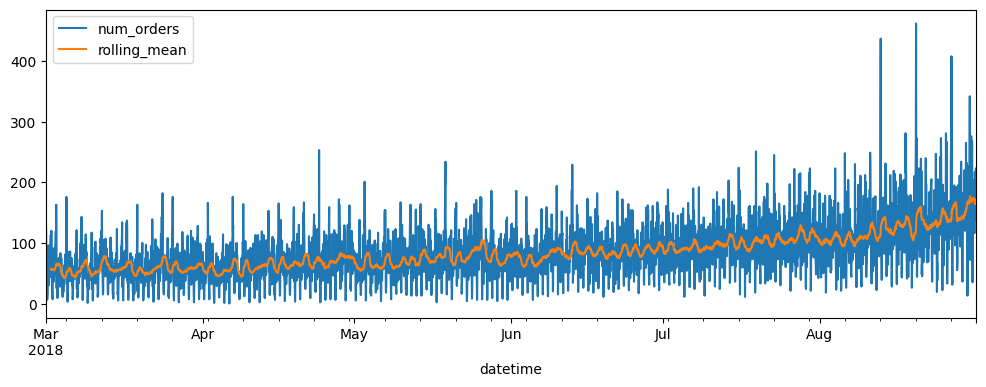

In [12]:
df[['num_orders','rolling_mean']].plot(figsize=(12,4))

Al graficar la serie original (num_orders) junto con su media móvil (rolling_mean), se pueden observar varios patrones importantes:

Existe una tendencia general creciente en la demanda de taxis a lo largo del periodo analizado.

Se detectan repeticiones diarias, lo cual sugiere una posible estacionalidad por hora o día de la semana.

La dispersión de los pedidos varía bastante durante el día: hay horas con demanda baja y otras con picos muy marcados.

En el mes de agosto, se observan varios picos pronunciados, lo que podría indicar eventos específicos o cambios estacionales.

## Formación

### Entrenamiento de modelos.

#### Regresión Lineal

In [13]:
lr = LinearRegression()
lr.fit(features_train, target_train)

#Predicciones
lr_pred = lr.predict(features_test)

#Calculo de RMSE
rmse_lr = np.sqrt(mean_squared_error(target_test, lr_pred))
print(f"RMSE (Regresión lineal): {rmse_lr:.2f}")

RMSE (Regresión lineal): 51.35


#### Random Forest

In [14]:
#Entrenar modelo
randomf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=12345)
randomf.fit(features_train, target_train)

#Predicciones
randomf_pred = randomf.predict(features_test)

#Calcular RMSE
rmse_randomf = np.sqrt(mean_squared_error(target_test, randomf_pred))
print(f"RMSE (Random Forest): {rmse_randomf:.2f}")

RMSE (Random Forest): 45.29


#### Decision Tree

In [15]:
#Entrenar modelo
tree = DecisionTreeRegressor(max_depth=9, random_state=12345)
tree.fit(features_train, target_train)

#Predicciones
tree_pred = tree.predict(features_test)

#Calcular RMSE
rmse_tree = np.sqrt(mean_squared_error(target_test, tree_pred))
print(f"RMSE (Árbol de decisión): {rmse_tree:.2f}")


RMSE (Árbol de decisión): 51.92


#### LightGBM

In [16]:
#Entrenar modelo
lgb = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=12345
)
lgb.fit(features_train, target_train)

#Predicciones
target_pred_lgb = lgb.predict(features_test)

#Calcular RMSE
rmse_lgbm = np.sqrt(mean_squared_error(target_test, target_pred_lgb))
print(f"RMSE (Light): {rmse_lgbm:.2f}")

RMSE (Light): 42.63


#### CatBoost

In [17]:
#Entrenar modelo
cat_model = CatBoostRegressor(
    iterations=500,
    depth=10,
    learning_rate=0.1,
    random_state=12345,
    verbose=10
)
cat_model.fit(features_train, target_train)

# Predicciones
target_pred_cat = cat_model.predict(features_test)

#Calcular RMSE
rmse_cat = np.sqrt(mean_squared_error(target_test, target_pred_cat))
print(f"RMSE (CatBoost): {rmse_cat:.2f}")

0:	learn: 36.7645211	total: 61.7ms	remaining: 30.8s
10:	learn: 26.6193557	total: 195ms	remaining: 8.67s
20:	learn: 22.8413789	total: 333ms	remaining: 7.59s
30:	learn: 21.1329813	total: 465ms	remaining: 7.04s
40:	learn: 20.1355877	total: 597ms	remaining: 6.68s
50:	learn: 19.2407607	total: 738ms	remaining: 6.5s
60:	learn: 18.4881494	total: 876ms	remaining: 6.31s
70:	learn: 17.7717855	total: 1.01s	remaining: 6.09s
80:	learn: 17.1866134	total: 1.14s	remaining: 5.91s
90:	learn: 16.5618448	total: 1.27s	remaining: 5.73s
100:	learn: 16.1212376	total: 1.41s	remaining: 5.57s
110:	learn: 15.4948592	total: 1.54s	remaining: 5.42s
120:	learn: 14.9571788	total: 1.68s	remaining: 5.27s
130:	learn: 14.4531646	total: 1.82s	remaining: 5.12s
140:	learn: 14.0164378	total: 1.95s	remaining: 4.97s
150:	learn: 13.5820255	total: 2.08s	remaining: 4.82s
160:	learn: 13.0519981	total: 2.22s	remaining: 4.68s
170:	learn: 12.4754959	total: 2.36s	remaining: 4.54s
180:	learn: 12.1405690	total: 2.5s	remaining: 4.4s
190:	l

## Prueba

In [18]:
# Crear un DataFrame comparativo
comparison = pd.DataFrame({
    'real': target_test,                        # valores reales
    'Linear': lr_pred,                         # modelo de regresión lineal
    'RandomForest': randomf_pred,               # random forest
    'Decision Tree': tree_pred,                 # Decision tree
    'CatBoost': target_pred_lgb,                # catboost
    'LightGBM': target_pred_cat                 # lightgbm
}) 

# Mostrar las primeras filas para comparación de predicciones vs el numero real de viajes.
comparison.head(10)

,real,Linear,RandomForest,Decision Tree,CatBoost,LightGBM
datetime,,,,,,
2018-08-13 14:00:00,102,111.297030,91.932076,92.668394,96.698188,97.330791
2018-08-13 15:00:00,175,109.054284,114.476352,92.668394,112.044574,115.830529
2018-08-13 16:00:00,144,141.072347,136.659002,132.806452,146.242545,146.646252
2018-08-13 17:00:00,152,135.878736,133.117281,132.806452,144.305815,120.850099
2018-08-13 18:00:00,104,136.429951,118.803827,132.806452,121.467387,107.397555
2018-08-13 19:00:00,91,111.273074,99.090585,90.490909,99.279846,102.919152
2018-08-13 20:00:00,82,104.714504,108.246683,90.490909,104.471257,97.919534
2018-08-13 21:00:00,160,97.194271,120.707041,107.060000,107.550892,103.209180
2018-08-13 22:00:00,104,138.486487,133.433114,132.806452,146.317164,116.619657


## Conclusión

En este proyecto teniamos como objetivo desarrollar un modelo que fuera capaz de predecir el número de viajes solicitados por hora, Sweet Lift Taxi nos proporciono los datos para poder realizar el estudio, preparación y entrenamiento de los modelos. 

Comenzamos realizando un remuestreo a intervalos de 1 hora de acuerdo a los requerimientos. Se preparo el dataset para obtener los conjuntos de entrenamiento y testeo de los modelos. 

En el analisis encontramos que el número de pedidos tiene un aumento progesivo al avanzar el año.
Posteriormente comprobamos el RMSE de cada modelo para evaluar cual cumplia con el objetivo de menos de 48. 

Usamos varios modelos:

Regresión Lineal

Árbol de Decisión

Random Forest

CatBoost

LightGBM

Probamos con distintos hiperparámetros.

Resultados
El mejor modelo fue LightGBM, que logró un RMSE de 42.63, cumpliendo con el requisito de estar por debajo de 48.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48